In [5]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import os

os.listdir('/gdrive/My Drive/러닝스푼즈/Lec 3/')

['model_cnn.pth',
 'model_mlp.pth',
 'CNN을 사용하여 CIFAR10 학습 및 예측하기.ipynb',
 'MLP를 사용하여 CIFAR10 학습 및 예측하기.ipynb',
 'data',
 '[Lab3]걸그룹_인식하기.ipynb']

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024,
                                          shuffle=True, num_workers=2)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


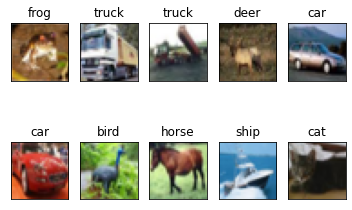

In [ ]:
fig = plt.figure()
 
for i in range(10):
    # 2x5 그리드에 i+1번째 subplot을 추가하고 얻어옴
    subplot = fig.add_subplot(2, 5, i + 1)

    # x, y 축의 지점 표시를 안함
    subplot.set_xticks([])
    subplot.set_yticks([])

    # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
    subplot.set_title('%s' % classes[train_dataset[i][1]])

    img = train_dataset[i][0] / 2 + 0.5     # unnormalize
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    
    subplot.imshow(img)

plt.show()

In [14]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 미리 학습 되어 있는 weight를 이용하여 예측하기

In [9]:
checkpoint = torch.load('/gdrive/My Drive/러닝스푼즈/Lec 3/model_cnn.pth')

In [15]:
model = ConvNet(num_classes=10).to(device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [16]:
checkpoint = torch.load('/gdrive/My Drive/러닝스푼즈/Lec 3/model_cnn.pth')

model = ConvNet(num_classes=10).to(device)
model.load_state_dict(checkpoint)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(val_loader):
        images, labels = batch[0], batch[1]
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 71.66 %


In [4]:
learning_rate = 0.001
num_epochs = 1000
best_acc = 0
# Loss and optimizer
model = ConvNet(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = []
    model.train()
    for i, batch in enumerate(train_loader):
        images, labels = batch[0], batch[1]
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
    .format(epoch+1, num_epochs, i+1, total_step, sum(total_loss)/len(total_loss)))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, batch in enumerate(val_loader):
            images, labels = batch[0], batch[1]
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_acc = 100 * correct / total
        print('Test Accuracy of the model on the test images: {} %'.format(val_acc))
        
        if val_acc > best_acc:
            best_acc = val_acc
            print('save_model!!!')
            #torch.save(model.state_dict(), '/gdrive/My Drive/러닝스푼즈/Lec 3/model_cnn.pt') # 저장될 weight의 이름을 지정하세요 (예시: '****.pth' ****에 원하는 파일명을 쓰세요)

Epoch [1/1000], Step [49/49], Loss: 1.6953
Test Accuracy of the model on the test images: 46.91 %
save_model!!!
Epoch [2/1000], Step [49/49], Loss: 1.4917
Test Accuracy of the model on the test images: 57.35 %
save_model!!!
Epoch [3/1000], Step [49/49], Loss: 1.3747
Test Accuracy of the model on the test images: 59.91 %
save_model!!!
Epoch [4/1000], Step [49/49], Loss: 1.2925
Test Accuracy of the model on the test images: 62.65 %
save_model!!!
Epoch [5/1000], Step [49/49], Loss: 1.2287
Test Accuracy of the model on the test images: 65.25 %
save_model!!!
Epoch [6/1000], Step [49/49], Loss: 1.1778
Test Accuracy of the model on the test images: 64.3 %
Epoch [7/1000], Step [49/49], Loss: 1.1364
Test Accuracy of the model on the test images: 65.06 %
Epoch [8/1000], Step [49/49], Loss: 1.1009
Test Accuracy of the model on the test images: 66.84 %
save_model!!!
Epoch [9/1000], Step [49/49], Loss: 1.0706
Test Accuracy of the model on the test images: 66.82 %
Epoch [10/1000], Step [49/49], Loss

KeyboardInterrupt: ignored